In [16]:
# 0. Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib


In [3]:

# 1. Load dataset
df = pd.read_csv('heart.xls')
display(df.shape)
display(df.head())

(1025, 14)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
# 2. Quick info
display(df.info())
display(df.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


None

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [5]:
# 3. Cek missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


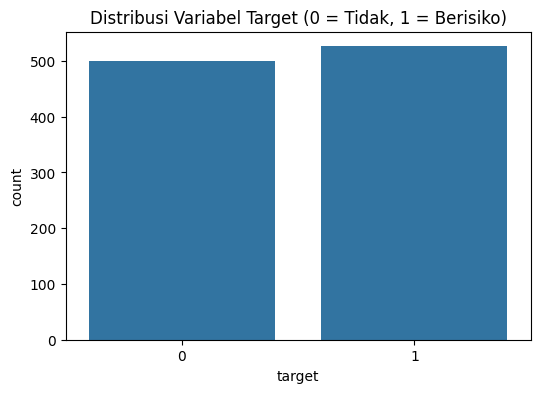

In [6]:
# 4. Visualisasi distribusi target
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df)
plt.title('Distribusi Variabel Target (0 = Tidak, 1 = Berisiko)')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

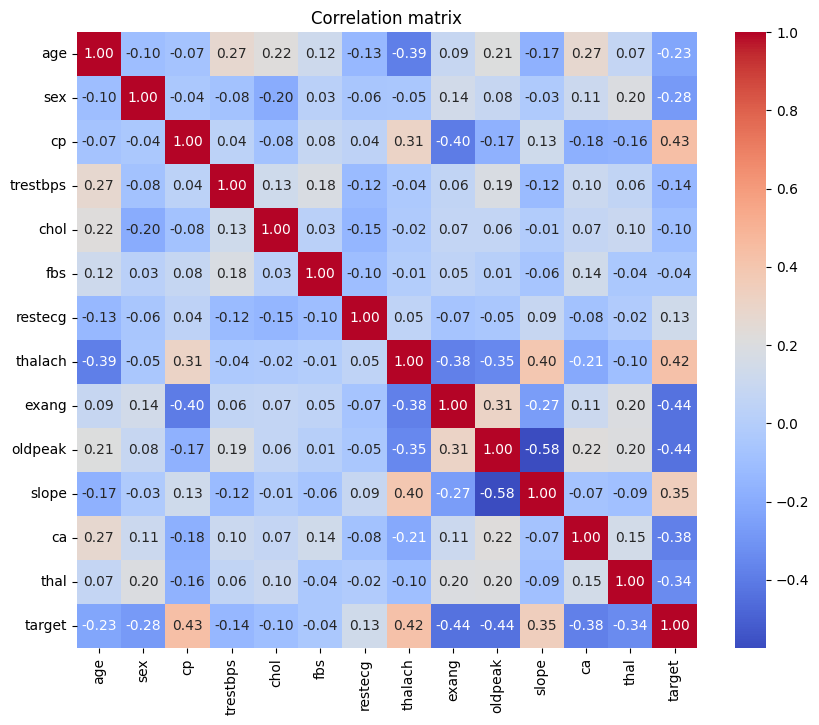

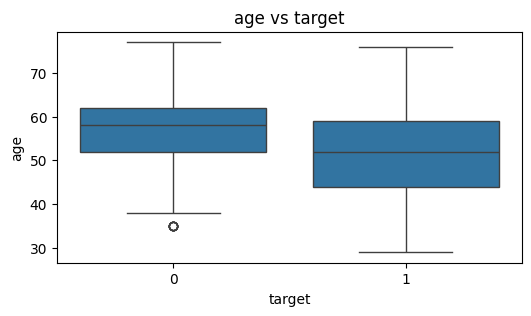

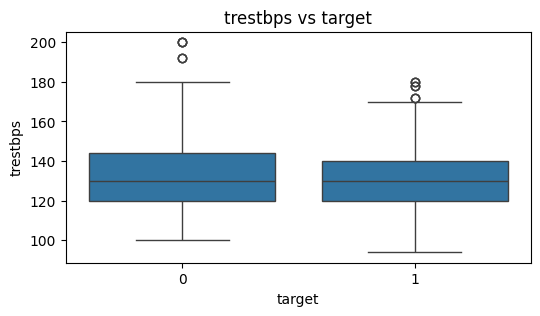

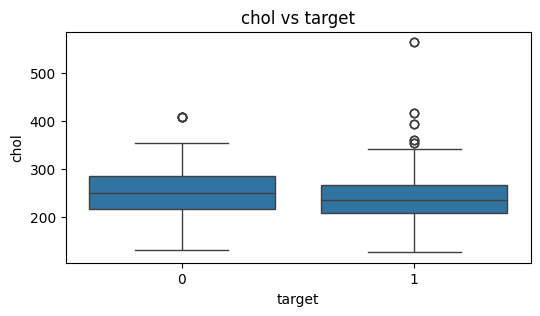

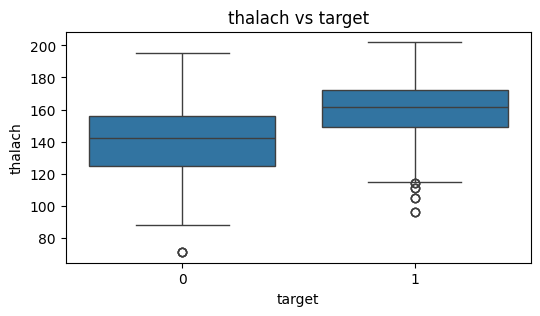

In [7]:
# 5. Exploratory plots: korelasi, beberapa fitur vs target
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

# Contoh hubungan fitur numerik dengan target
num_features = ['age','trestbps','chol','thalach']
for f in num_features:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='target', y=f, data=df)
    plt.title(f'{f} vs target')
    plt.show()

In [9]:
# 6. Pra-pemrosesan
# a) Tentukan fitur numerik dan kategorikal (sesuaikan dataset)
# contoh umum pada dataset heart:
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'] if 'oldpeak' in df.columns else ['age','trestbps','chol','thalach']
cat_cols = [c for c in df.columns if c not in num_cols + ['target']]

print("Numerical:", num_cols)
print("Categorical:", cat_cols)

# b) Tangani missing (jika ada)
# Strategie sederhana: numeric -> median, categorical -> mode
for c in num_cols:
    if df[c].isnull().sum()>0:
        df[c].fillna(df[c].median(), inplace=True)
for c in cat_cols:
    if df[c].isnull().sum()>0:
        df[c].fillna(df[c].mode()[0], inplace=True)

# c) Encoding: gunakan One-Hot untuk kategorikal nominal
X = df.drop(columns=['target'])
y = df['target']

# Simpel pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# d) Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fit preprocessor
preprocessor.fit(X_train)
X_train_p = pd.DataFrame(preprocessor.transform(X_train))
X_test_p = pd.DataFrame(preprocessor.transform(X_test))

print("Transformed shapes:", X_train_p.shape, X_test_p.shape)

Numerical: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Transformed shapes: (820, 30) (205, 30)


In [10]:
# 7. Model A: Decision Tree tanpa batas (overfit possible)
modelA = DecisionTreeClassifier(random_state=42)
modelA.fit(X_train_p, y_train)

# Evaluasi Model A
y_train_predA = modelA.predict(X_train_p)
y_test_predA = modelA.predict(X_test_p)

print("=== Model A (no restrictions) ===")
print("Train accuracy:", accuracy_score(y_train, y_train_predA))
print("Test accuracy:", accuracy_score(y_test, y_test_predA))
print("\nClassification report (test):\n", classification_report(y_test, y_test_predA))
print("Confusion matrix (test):\n", confusion_matrix(y_test, y_test_predA))


=== Model A (no restrictions) ===
Train accuracy: 1.0
Test accuracy: 0.9853658536585366

Classification report (test):
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

Confusion matrix (test):
 [[100   0]
 [  3 102]]


In [11]:
# 8. Model B: pruned model (batasi depth)
modelB = DecisionTreeClassifier(max_depth=4, min_samples_leaf=8, random_state=42)
modelB.fit(X_train_p, y_train)

# Evaluasi Model B
y_train_predB = modelB.predict(X_train_p)
y_test_predB = modelB.predict(X_test_p)

print("\n=== Model B (pruned) ===")
print("Train accuracy:", accuracy_score(y_train, y_train_predB))
print("Test accuracy:", accuracy_score(y_test, y_test_predB))
print("\nClassification report (test):\n", classification_report(y_test, y_test_predB))
print("Confusion matrix (test):\n", confusion_matrix(y_test, y_test_predB))


=== Model B (pruned) ===
Train accuracy: 0.8658536585365854
Test accuracy: 0.848780487804878

Classification report (test):
               precision    recall  f1-score   support

           0       0.85      0.84      0.84       100
           1       0.85      0.86      0.85       105

    accuracy                           0.85       205
   macro avg       0.85      0.85      0.85       205
weighted avg       0.85      0.85      0.85       205

Confusion matrix (test):
 [[84 16]
 [15 90]]


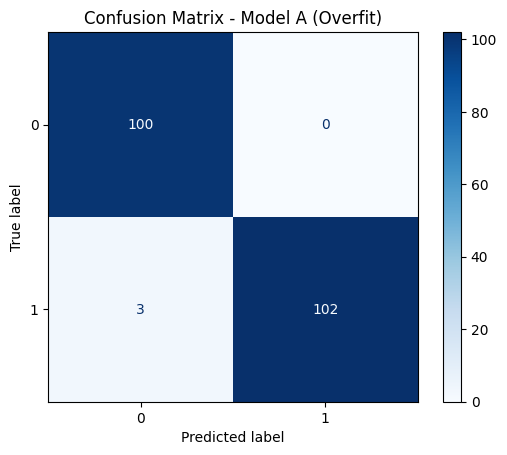

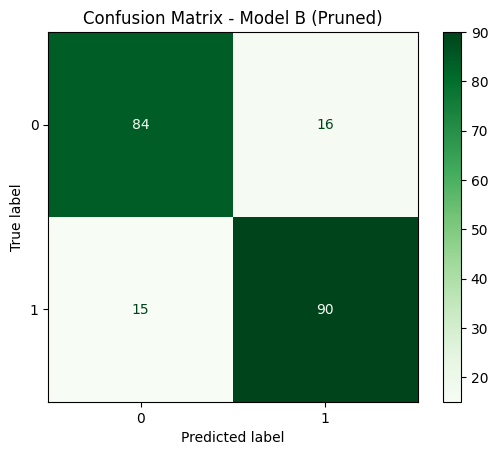

In [17]:
# Confusion matrix untuk Model A (Overfit)
y_predA = modelA.predict(X_test_p)
cmA = confusion_matrix(y_test, y_predA)
dispA = ConfusionMatrixDisplay(confusion_matrix=cmA, display_labels=modelA.classes_)
dispA.plot(cmap='Blues')
plt.title('Confusion Matrix - Model A (Overfit)')
plt.show()

# Confusion matrix untuk Model B (Pruned)
y_predB = modelB.predict(X_test_p)
cmB = confusion_matrix(y_test, y_predB)
dispB = ConfusionMatrixDisplay(confusion_matrix=cmB, display_labels=modelB.classes_)
dispB.plot(cmap='Greens')
plt.title('Confusion Matrix - Model B (Pruned)')
plt.show()

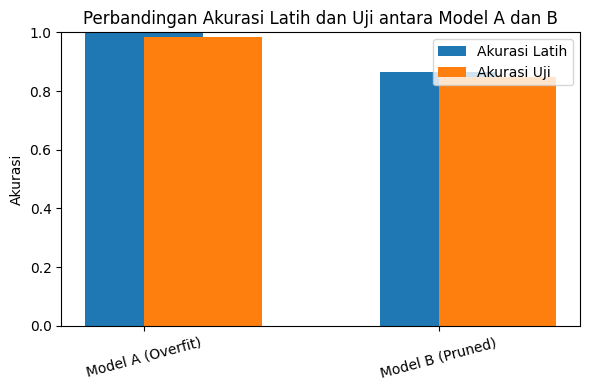

In [18]:
# Hitung akurasi train dan test dari kedua model
train_acc_A = modelA.score(X_train_p, y_train)
test_acc_A = modelA.score(X_test_p, y_test)
train_acc_B = modelB.score(X_train_p, y_train)
test_acc_B = modelB.score(X_test_p, y_test)

# Buat plot perbandingan
labels = ['Model A (Overfit)', 'Model B (Pruned)']
train_acc = [train_acc_A, train_acc_B]
test_acc = [test_acc_A, test_acc_B]

x = range(len(labels))
plt.figure(figsize=(6,4))
plt.bar(x, train_acc, width=0.4, label='Akurasi Latih', align='center')
plt.bar(x, test_acc, width=0.4, label='Akurasi Uji', align='edge')
plt.xticks(x, labels, rotation=15)
plt.ylabel('Akurasi')
plt.ylim(0, 1)
plt.title('Perbandingan Akurasi Latih dan Uji antara Model A dan B')
plt.legend()
plt.tight_layout()
plt.show()


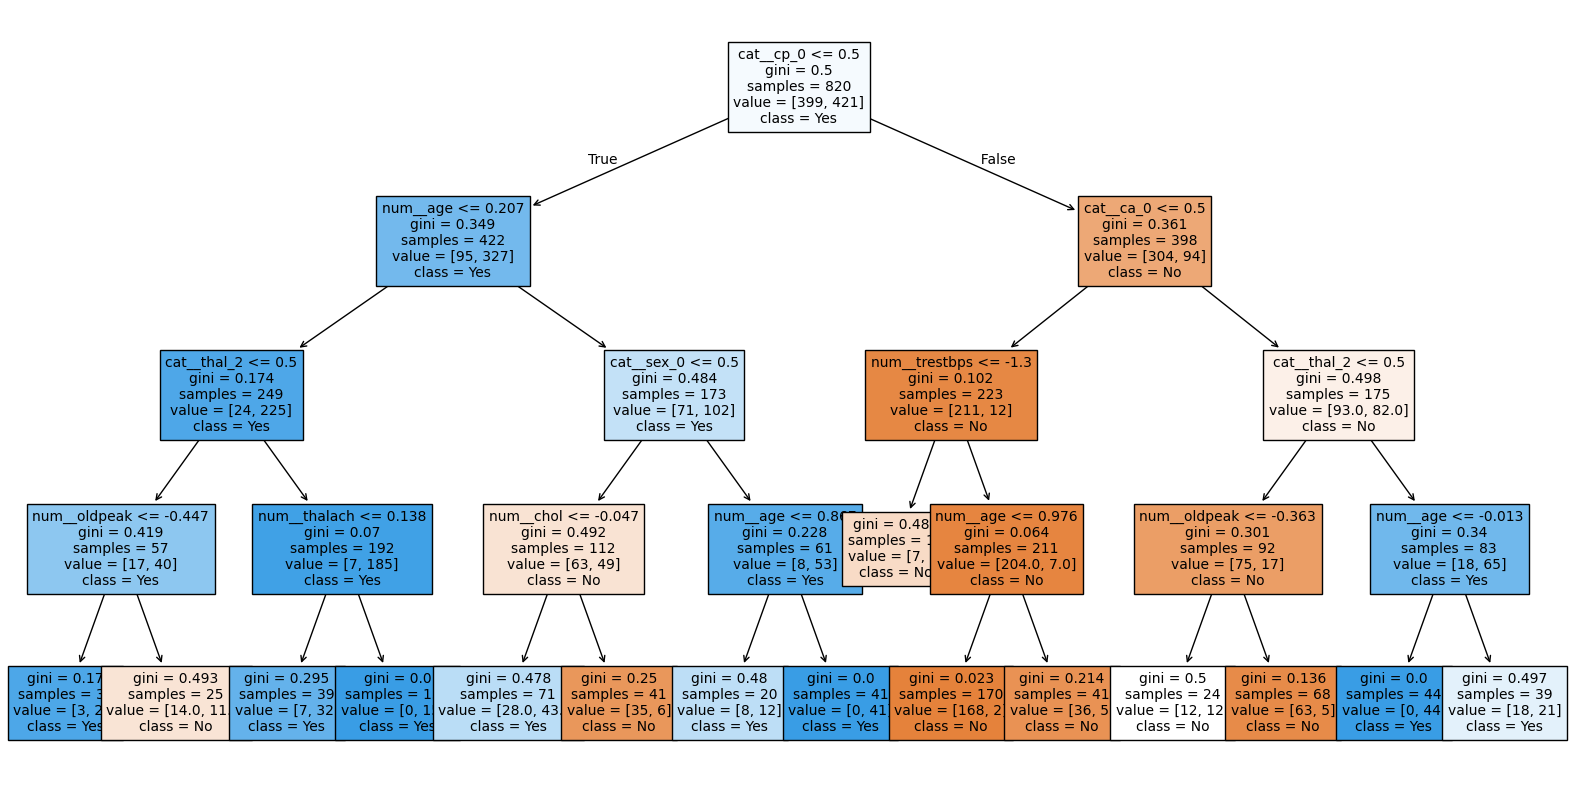

In [10]:
# 9. Visualisasi pohon Model B
plt.figure(figsize=(20,10))
plot_tree(modelB, filled=True, feature_names=list(preprocessor.get_feature_names_out()), class_names=['No','Yes'], fontsize=10)
plt.show()


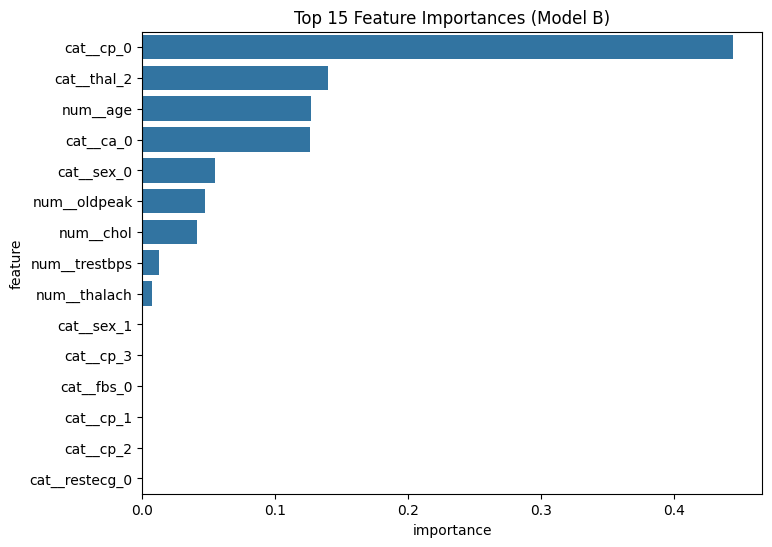

In [11]:
# 10. Feature importances (Model B)
importances = modelB.feature_importances_
feat_names = list(preprocessor.get_feature_names_out())
feat_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
feat_df = feat_df.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_df)
plt.title('Top 15 Feature Importances (Model B)')
plt.show()

In [12]:
# 11. Simpan model terbaik (ambil Model B)
joblib.dump({
    'preprocessor': preprocessor,
    'model': modelB
}, 'dt_heart_pipeline.joblib')

print("Model saved as dt_heart_pipeline.joblib")

Model saved as dt_heart_pipeline.joblib
